## Predicting Precipitation Type (Classifier)

#### *By: Heaton Chan, Rana Ghadymimahani, Amitaditya Paul, and Renee Choquette*

### Introduction:

One of the aspects that has a great impact on our day-to-day lives, yet that humans have very little control over, is the weather. Accurately predicting future weather has been a constant pursuit for many years, especially with the implications of global warming, which have been causing erratic changes to the climate. We believe that computer analysis is one of the most promising methods to achieve accurate weather predictions. In our project, we will be exploring a weather dataset to answer the following question: “Given the weather data of a region in the United States, what type of precipitation (if any) will occur?”. The original dataset contains weather data from different countries in the year of 2020, but we chose to focus only on data from the United States (see Expected Outcome and Significance for reasoning) and the following predictors: dew point, daily high temperature, daily low temperature, humidity, pressure, and probability of precipitation. 

### Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [29]:
weather_data_raw <- suppressWarnings(read_csv("data/daily_weather_2020.csv")) %>%
    select(-X1) %>% # removing first column because it only contains the number of rows
    rename(Country = "Country/Region") # renaming column because having a "/" in column name can lead to errors

names <- colnames(weather_data_raw) # So that we can see all the column names in the dataframe
count <- weather_data_raw %>%
            group_by(Country) %>%
            summarize(number_of_rows = n()) %>%
            arrange(desc(number_of_rows)) # So that we can see the rows of data we have to work with in each region         

weather_data_US_only <- weather_data_raw %>%
            select(Country, precipProbability, temperatureHigh, temperatureLow, dewPoint, humidity, pressure, precipType) %>%
            filter(Country == "US") # dataframe that only contains data from US

na_count <- weather_data_US_only %>%
            is.na() %>%
            sum() %>%
            as.data.frame() %>%
            rename(number_of_missing = ".") #formally showing number of missing values in a weather_data_US_only dataframe

weather_data <- weather_data_US_only %>% 
    mutate(precipType = ifelse(is.na(precipType), 'none', precipType)) %>%
    mutate(precipType = as.factor(precipType)) %>%
    drop_na()  # final dataframe without NA's
    
na_count_final <- weather_data %>%
            is.na() %>%
            sum() %>%
            as.data.frame() %>%
            rename(number_of_missing = ".") #formally showing number of missing values in a weather_data dataframe

Parsed with column specification:
cols(
  .default = col_double(),
  `Country/Region` = col_character(),
  `Province/State` = col_character(),
  time = col_date(format = ""),
  summary = col_character(),
  icon = col_character(),
  precipType = col_character()
)

See spec(...) for full column specifications.

`summarise()` ungrouping output (override with `.groups` argument)



`summarise()` ungrouping output (override with `.groups` argument)



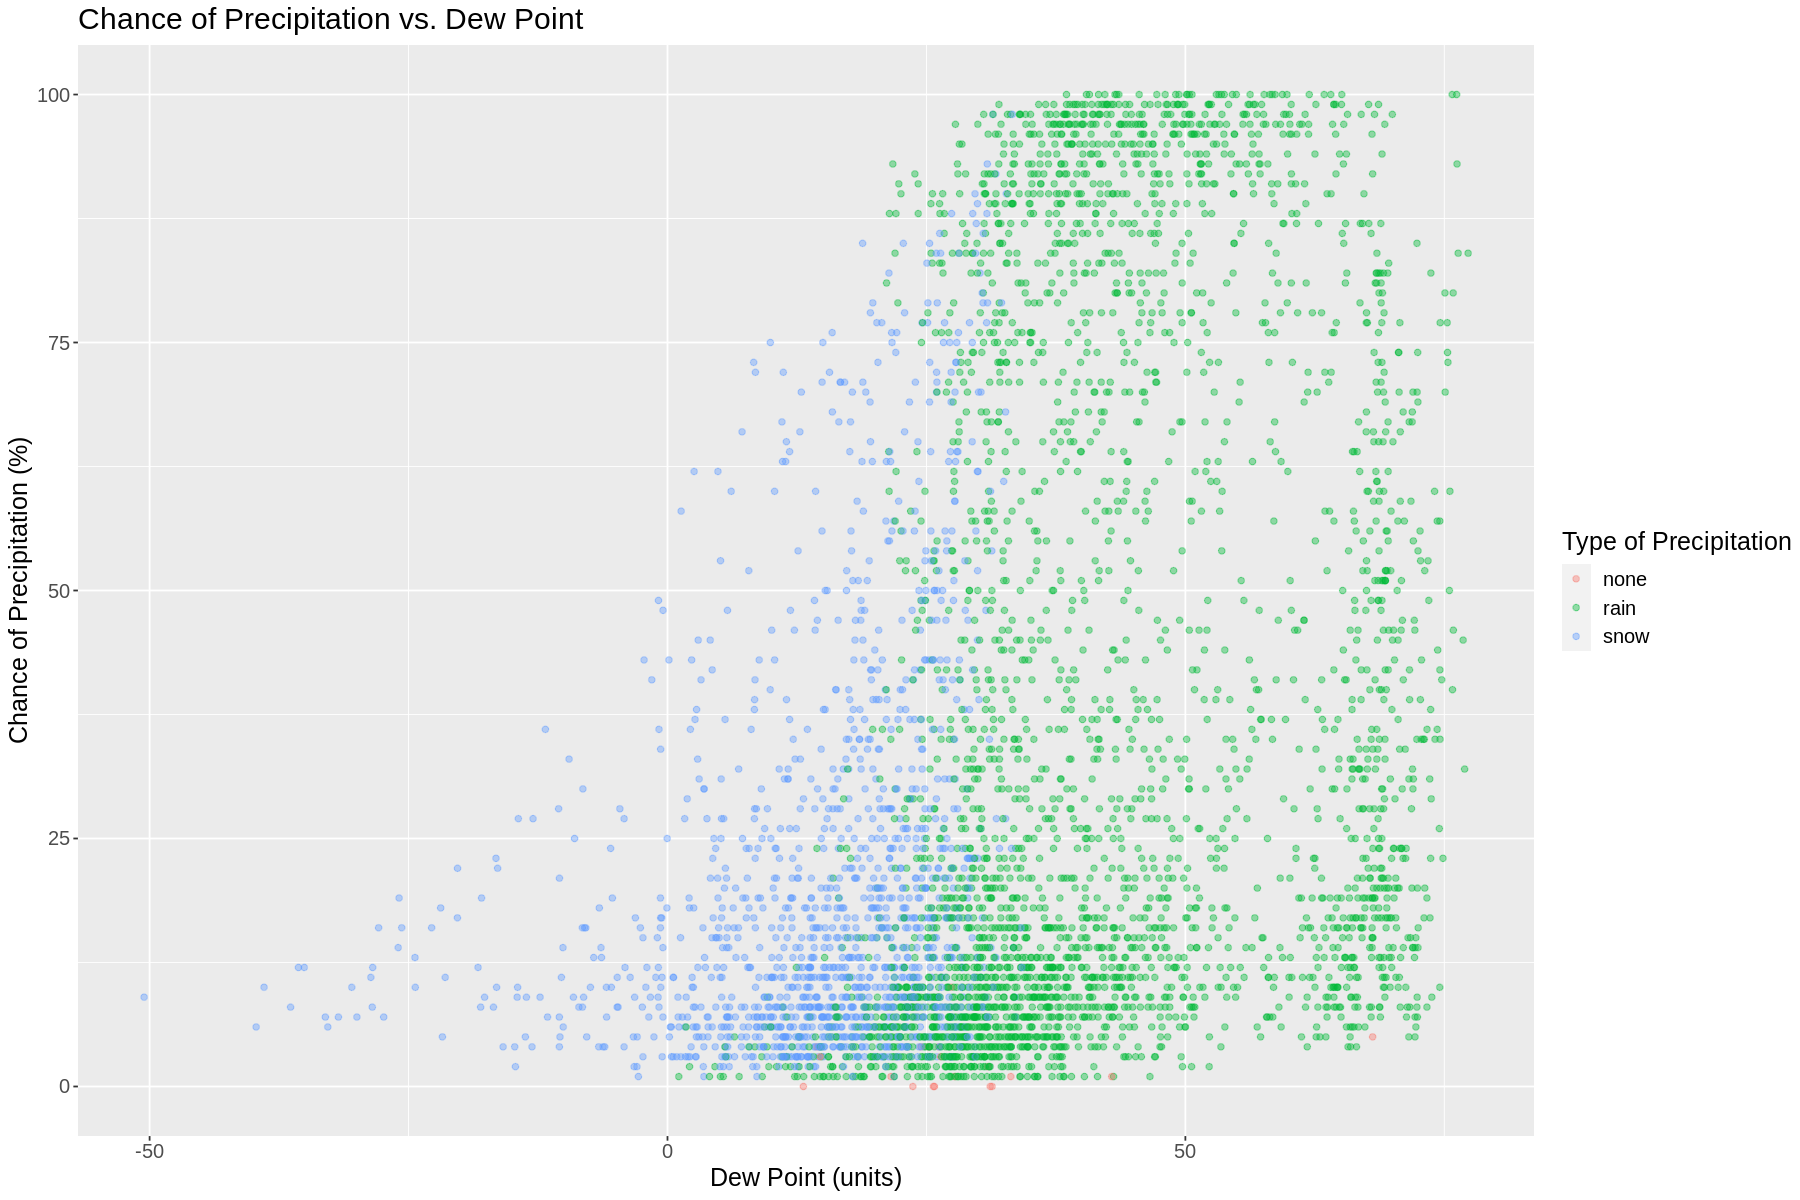

In [16]:
weather_split <- weather_data %>%
                    initial_split(prop = 0.75, strata = precipProbability) #just the thing we have to do to create the split object

weather_training <- training(weather_split) #training dataset
weather_testing <- testing(weather_split) #testing dataset

weather_train_means <- weather_training %>%
                            select(-Country, -precipType) %>%
                            map_df(mean) #computed means for across all columns

weather_train_total <- weather_training %>%
                            group_by(Country) %>%
                            summarize(number_of_rows = n()) #computed total number of rows

weather_train_aggregate <- weather_train_total %>%
                                bind_cols(weather_train_means) #aggregated summary tables for the training data 

options(repr.plot.width = 15, repr.plot.height = 10)
weather_train_plot <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = dewPoint, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Dew Point (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Chance of Precipitation vs. Dew Point") 
weather_train_plot
                        

In [12]:
# Planning to maybe have this code cell store the summary tables

unified_tibble <- slice(count, 1) %>%
                    bind_cols(na_count_final)
unified_tibble

Country,number_of_rows,number_of_missing
<chr>,<int>,<int>
US,6272,0


### Methods:

Our goal is to predict what type of precipitation (rain, snow, or none) will occur based on the following variables; dew point, daily high temperature, daily low temperature, humidity, pressure, and probability of precipitation, with a focus on the US region. We will do this by splitting our original dataset into a training set (75% of original data) and a testing set (25% of original). We will then use the training data set to train our classifier to predict the type of precipitation using a K-nearest neighbor model. Prior to building our model, we will perform a cross-fold analysis to obtain a K-value with the highest accuracy. Next, we will run our classifier on our testing set and measure how accurately it performed. Finally, we will use those results to graph the proportion of data points our classifier predicted correctly and incorrectly. We will use a bar plot to produce such a visualization, as bar plots are preferred when visualizing proportions in data. We may also graph scatter plots of our different predictors to visualize trends in our data. Furthermore, we have provided an example of a precipitation probability vs. dew point graph above, but this data set provides many variables that we can measure and explore, to increase the accuracy of our prediction. 

### Expected outcomes and significance:

We expect to find the precipitation type in the US, based on past data of humidity levels, daily low and high temperatures, pressure, dew points, and probability of precipitation. We chose the US as our focal country, because it has the greatest amount of data in the dataset and will likely allow us to produce a more accurate classifier. The goal of predicting the type of precipitation is to provide information that people and organizations can use to reduce weather-related losses and enhance societal benefits. This includes, protecting life and property, public health and safety, and support of economic prosperity and quality of life, as well as alerting businesses that rely on weather (like farming or fishing), warning drivers to be cautious on the roads with certain weather conditions, to notify people how they should dress to stay safe and warm. Another question our findings may lead to is, when will each type of precipitation occur and in what amounts?
